# LSTM Dynamic Sign Language Recognition Training Notebook

# 1. Import and Install Dependencies

In [2]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [3]:
#!pip install mediapipe

In [1]:
#!python -m ipykernel install --user --name=C:\Users\Zhili\.conda\envs\lstm_keypoint

In [2]:
!pip install -r requirements.txt --user

  Using cached https://files.pythonhosted.org/packages/68/8c/42bbb31a25a708e2e24881724ec7bcea05530492de8b1a2e0d8fe43eb2f6/tensorflow-2.4.1-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/ff/18/60ac053857fb924b0324c81200b59c00317ebaa3c14b7478266b50ffed19/numpy-1.19.5-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/3b/f8/edee615ebd1c076b55691ffd7bc1419eecb6db8c8a1dcbf4a8f1241cf1ec/matplotlib-3.4.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/94/42/d8bca8e99789bcc35dfa9b03acaa8b518720d6e060163745bc2bf2ead842/Jinja2-3.0.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/48/58/c8aa6a8e62cc75f39fee1092c45d6b6ba684122697d7ce7d53f64f98a129/click-8.0.3-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1e/73/51137805d1b8d97367a8a77cae4a792af14bb7ce58fbd071af294c740cf0/Werkzeug-2.0.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/

ERROR: astroid 2.3.1 requires typed-ast<1.5,>=1.4.0; implementation_name == "cpython" and python_version < "3.8", which is not installed.
ERROR: fiona 1.8.4 has requirement click<8,>=4.0, but you'll have click 8.0.3 which is incompatible.
ERROR: astroid 2.3.1 has requirement six==1.12, but you'll have six 1.15.0 which is incompatible.
ERROR: astroid 2.3.1 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
from platform import python_version
print(python_version())

3.7.4


In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Visualizing Keypoints using MediaPipe (MP Holistic)

Reference for Google's Mediapipe API: https://google.github.io/mediapipe/solutions/holistic.html

In [3]:
# Use Holistic Models for detections
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities


# Make keypoint detection, model can only detect in RGB
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB as model can only detect in RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Use Model to make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results): # draw landmarks for each image/frame
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    
def draw_styled_landmarks(image, results): # draw landmarks for each image/frame, fix colour of landmark drawn
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

### 2.1 Open Computer Webcam using opencv

In [7]:
# Use computer webcam
cap = cv2.VideoCapture(0)
# Set mediapipe model 

while cap.isOpened(): #open webcam
    # Read feed
    ret, frame = cap.read()
    # Show to screen
    cv2.imshow('OpenCV Feed: Hold Q to Quit', frame)
    # Break gracefully
    if cv2.waitKey(10) & 0xFF == ord('q'): #press q to quit
        break
cap.release() #release webcam
cv2.destroyAllWindows()

### 2.2 Use Computer Webcam and make mediapipe keypoint detections

In [14]:
# use computer webcam and make keypoint detections
cap = cv2.VideoCapture(0)

# Set mediapipe model configurations
min_detection_confidence = 0.5
min_tracking_confidence= 0.5

with mp_holistic.Holistic(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Make detections by calling our function
        image, results = mediapipe_detection(frame, holistic) #mediapipe_detection(image, model) 
        #print(results)
        #print(results.face_landmarks)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed: Hold Q to Quit', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'): #press q to quit
            break
    cap.release() #release webcam
    cv2.destroyAllWindows()

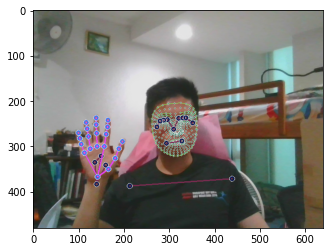

In [19]:
#show last frame with keypoints drawn using draw styled landmarks
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

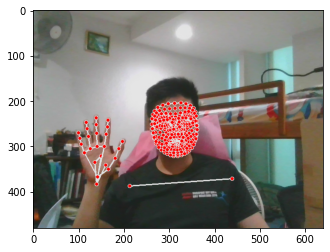

In [20]:
# call helper function to draw landmarks
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values to be used for our model training

In [25]:
#Show length of landmarks x,y,z spatial coordinates for right hand pose
len(results.right_hand_landmarks.landmark)

21

In [26]:
# Show Results of landmark x,y,z spatial coordinates for face landmarks
print('Length of face landmarks:',len(results.face_landmarks.landmark))
print('Results Type:',type(results.face_landmarks))
print('Face landmarks Results:',results.face_landmarks)

# Convert facelandmarks to numpy array
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark])if results.face_landmarks else np.zeros(468*3)
print(face)

Length of face landmarks: 468
Results Type: <class 'mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList'>
Face landmarks Results: landmark {
  x: 0.4967149794101715
  y: 0.5952548980712891
  z: -0.02134861797094345
}
landmark {
  x: 0.49652066826820374
  y: 0.5636536478996277
  z: -0.035830751061439514
}
landmark {
  x: 0.49612709879875183
  y: 0.5739929676055908
  z: -0.019394272938370705
}
landmark {
  x: 0.48873019218444824
  y: 0.5337827801704407
  z: -0.026042670011520386
}
landmark {
  x: 0.49618616700172424
  y: 0.5538313984870911
  z: -0.037808019667863846
}
landmark {
  x: 0.4953863322734833
  y: 0.5415613055229187
  z: -0.034722063690423965
}
landmark {
  x: 0.4930804371833801
  y: 0.5124167799949646
  z: -0.015270167030394077
}
landmark {
  x: 0.44216325879096985
  y: 0.5158998370170593
  z: 0.00844527781009674
}
landmark {
  x: 0.49176058173179626
  y: 0.48921260237693787
  z: -0.01004682295024395
}
landmark {
  x: 0.49126020073890686
  y: 0.47597891092300415
  

In [27]:
# Show Pose Connection Results
print('Pose Connection Results:',mp_holistic.POSE_CONNECTIONS)

# getting the landmarks x,y,z coordinates
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)
print(pose)

Pose Connection Results: frozenset({(30, 32), (5, 6), (24, 26), (26, 28), (11, 23), (25, 27), (15, 19), (3, 7), (27, 29), (1, 2), (28, 30), (29, 31), (12, 24), (16, 22), (0, 4), (16, 18), (18, 20), (11, 13), (23, 25), (17, 19), (12, 14), (4, 5), (13, 15), (9, 10), (2, 3), (28, 32), (27, 31), (11, 12), (23, 24), (15, 17), (0, 1), (6, 8), (14, 16), (15, 21), (16, 20)})
[array([ 0.48582965,  0.54786313, -0.57296729,  0.99998981]), array([ 0.50260133,  0.4958922 , -0.53849137,  0.99996477]), array([ 0.51609278,  0.4949277 , -0.53818619,  0.99996126]), array([ 0.52776694,  0.49456826, -0.53806794,  0.99996328]), array([ 0.46344948,  0.50246775, -0.51727998,  0.99996942]), array([ 0.45135069,  0.50522006, -0.51691598,  0.99996918]), array([ 0.43871576,  0.50888473, -0.51701987,  0.99997616]), array([ 0.55081606,  0.517654  , -0.29148629,  0.99995661]), array([ 0.42792168,  0.53680336, -0.17905764,  0.99997222]), array([ 0.51378053,  0.60170645, -0.48577246,  0.99997461]), array([ 0.45954108,

In [29]:
# Using list comprehension to extract landmark results if landmark for body part is detected, else replace it with a blank array of zeros of the same shape for each body part    
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [30]:
print(pose.shape)
#print(pose)
print(face.shape)
print(lh.shape)
print(rh.shape)

(132,)
(1404,)
(63,)
(63,)


In [31]:
# define extract keypoint function and convert to numpy array to be saved
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    #return np.concatenate([pose, face, lh, rh]) # concatenate all the keypoints that are flattened
    return np.concatenate([pose, lh, rh])

result_test = extract_keypoints(results)

In [32]:
extract_keypoints(results).shape

(258,)

In [33]:
# Total number of coordinates in results (pose, face, left hand and right hand)
33*4 + 468*3 + 21*3 + 21*3

1662

In [34]:
# Total number of coordinates in results (pose, left hand and right hand)
33*4 + 21*3 + 21*3

258

In [124]:
# save results as numpy array
np.save('results', results)

In [125]:
#load numpy array
np.load('results.npy')

array([ 0.3835876 ,  0.47759178, -0.77978629, ...,  0.        ,
        0.        ,  0.        ])

In [41]:
# Remove face landmarks from old training dataset
import numpy as np
index = [i for i in range(132,1536)]
actions = np.array(['Bird','Butterfly','Cow','Elephant','Gorilla','No Action'])

for action in actions:
    print(action) 
        # Loop through sequences aka videos
    for sequence in range(1,no_sequences+1): #range(30,60) # 30....59
         
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            #print(frame_num)
            npy_path = DATA_PATH+ '/'+action+'/'+str(sequence)+'/'+str(frame_num)
            test_np = np.load(npy_path+'.npy')
            new_np = np.delete(test_np, index)
            
            #print(test_np)
            #print(npy_path)
            #print(new_np.shape)
            # save keypoints to folder
            #np.save(npy_path, new_np)

Bird
Butterfly
Cow
Elephant
Gorilla
No Action


# 4. Setup Folders for Collection of Keypoints for training LSTM model

In [3]:
# Path for exported data, numpy arrays
#DATA_PATH = os.path.join('MP_Data')
DATA_PATH = os.path.join('test') 

# Actions that we try to detect
#actions = np.array(['Elephant'])
actions = np.array(['Gorilla'])
#actions = np.array(['Alligator'])
#actions = np.array(['Butterfly'])
#actions = np.array(['Cow'])
#actions = np.array(['Bird'])
#actions = np.array(['No Action'])
#actions = np.array(['Alligator','Butterfly','Cow','Elephant','Gorilla'])

# 60 videos worth of data for each action
no_sequences = 60

# Videos are going to be 30 frames in length (30 frames of data for each action)
sequence_length = 30

# 60 *30 = 1800 frames collected for each action
# each frame will contain 258 landmark values or 1662  landmark values

# for example
# bird folder
    # 0: 30 frames
    # 1: 30 frames
    # 2: 30 frames
    # 3: 30 frames
    #.
    #.
    #.
    #59: 30 frames


In [4]:
#  loop through the actions we are detecting and make folders to store keypoints as numpy arrays
for action in actions: 
    #dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    # loop through the sequences that we are collecting
    for sequence in range(1,no_sequences+1):
        try: #if the directory do not exist, we create a new directory to store the frames
            #os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [6]:
#Capture Video using webcam
cap = cv2.VideoCapture(0)
# Set mediapipe model 
count = 0
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(1,no_sequences+1): #range(30,60) # 30....59
            
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                
                # Read feed
                ret, frame = cap.read()
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic # Implement Collection Breaks between each sequence to allow me to reset and reposition to collect the action from start to finish
                if frame_num == 0: #If frame is 0, take a break
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500) #wait for 0.5 seconds
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                
                #print(npy_path)
                #print(keypoints.shape)

                # save keypoints to folder
                np.save(npy_path, keypoints)
                #cv2.waitKey(10)
                cv2.imwrite(f'test/{count}.jpg', image)
                count+=1
                
                
            # Break gracefully
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
                    
    cap.release()
    cv2.destroyAllWindows()

In [7]:
import cv2
 
capture = cv2.VideoCapture(0)
 
fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
videoWriter = cv2.VideoWriter('testvideo.avi', fourcc, 30.0, (640,480))
 
while (True):
    ret, frame = capture.read()
     
    if ret:
        cv2.imshow('video', frame)
        videoWriter.write(frame)
    if cv2.waitKey(1) == 27:
        break
        
capture.release()
videoWriter.release()
 
cv2.destroyAllWindows()

# 6. Data Preparation

In [34]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import pandas as pd

In [35]:
#Define Path to training data of numpy arrays
#DATA_PATH = os.path.join('MP_Data_bp_hp')
#DATA_PATH = os.path.join('MP_Data-6classes') # including facemesh

DATA_PATH = os.path.join('MP_Data-5classes') # including facemesh

# Define Model Run
run = 'run15'

#Define directory to save training graphs and confusion matrices
img_dir = f'Logs/{run}/images'

# create directory if image directory does not exist
if not os.path.exists(img_dir):
    os.makedirs(img_dir)    

# Define actions that we try to detect
actions = np.array(['Alligator','Butterfly','Cow','Elephant','Gorilla'])
#actions = np.array(['Bird','Butterfly','Cow','Elephant','Gorilla','No Action'])

# Sixty videos worth of data for each action
no_sequences = 60
# Videos are going to be 30 frames in length (30 frames of data for each action)
sequence_length = 30

#create label map dictionary
label_map = {label:num for num, label in enumerate(actions)} 
print(label_map)

#sequences represent x data, labels represent y data/the action classes.
sequences, labels = [], []
#Loop through the action classes you want to detect
for action in actions:
    #loop through each sequence
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# X = Training Data that contains spatial coordinates x,y,z of landmarks
X = np.array(sequences)

# y = categorical labels
y = to_categorical(labels).astype(int) #one-hot-encoding to catergorical variable

print('X Shape:',X.shape)
print('y Shape:',y.shape)

# train test split (95% train,5% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify=y)

print('X_train Shape:',X_train.shape)
print('y_train Shape:',y_train.shape)
print('X_test Shape:',X_test.shape)
print('y_test Shape:',y_test.shape)

# split imbalanced dataset into train and test sets with stratification
test_count_label = tf.reduce_sum(y_test, axis=0)
train_count_label = tf.reduce_sum(y_train, axis=0)


{'Alligator': 0, 'Butterfly': 1, 'Cow': 2, 'Elephant': 3, 'Gorilla': 4}
X Shape: (300, 30, 1662)
y Shape: (300, 5)
X_train Shape: (240, 30, 1662)
y_train Shape: (240, 5)
X_test Shape: (60, 30, 1662)
y_test Shape: (60, 5)


In [46]:
# Show categorical list
actions.tolist()

['Bird', 'Butterfly', 'Cow', 'Elephant', 'Gorilla', 'No Action']

In [36]:
# Show categorical list
actions.tolist()

['Alligator', 'Butterfly', 'Cow', 'Elephant', 'Gorilla']

In [37]:
left = pd.DataFrame(train_count_label,columns=['train_count'])
right = pd.DataFrame(test_count_label,columns=['test_count'])
df = left.join(right)

actions_list = actions.tolist()

left = pd.DataFrame(actions_list,columns=['class_names'])
df = left.join(df)
df

class_names  train_count  test_count
0   Alligator           48          12
1   Butterfly           48          12
2         Cow           48          12
3    Elephant           48          12
4     Gorilla           48          12

In [3]:
left = pd.DataFrame(train_count_label,columns=['train_count'])
right = pd.DataFrame(test_count_label,columns=['test_count'])
df = left.join(right)

actions_list = actions.tolist()

left = pd.DataFrame(actions_list,columns=['class_names'])
df = left.join(df)
df

class_names  train_count  test_count
0        Bird           48          12
1   Butterfly           48          12
2         Cow           48          12
3    Elephant           48          12
4     Gorilla           48          12
5   No Action           48          12

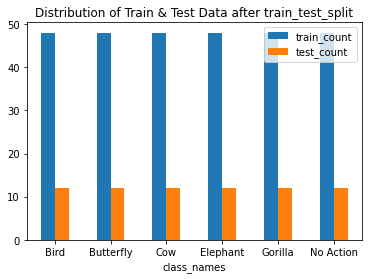

In [7]:
# Plot Distribution of Train & Test Data after train_test_split
ax = df.plot.bar(x='class_names',rot=0)
ax.set_title('Distribution of Train & Test Data after train_test_split')
ax.figure.savefig(f'{img_dir}/train_test_distribution.jpg')

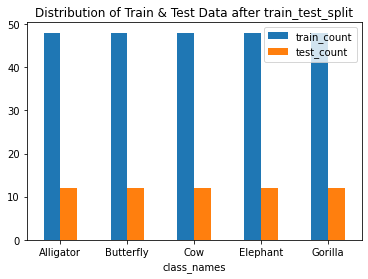

In [95]:
# Plot Distribution of Train & Test Data after train_test_split
ax = df.plot.bar(x='class_names',rot=0)
ax.set_title('Distribution of Train & Test Data after train_test_split')
ax.figure.savefig('images/train_test_distribution.png')

# 7. Training LSTM Model

In [38]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

#Set up log directory to monitor training accuracy while training
log_dir = os.path.join('Logs/{}'.format(run))
tb_callback = TensorBoard(log_dir=log_dir)

model_dir = 'Logs/{}/model'.format(run)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


## 7.1 Build LSTM Neural Network using Keras

In [46]:
del model

#### Experiment 1: 5 Classes (Facemesh, Hand pose and Body pose keypoints for training data)

In [47]:
# Build LSTM Model Architecture Layers using Keras high-level # run 1
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

#### Experiment 2: 6 Classes (Facemesh, Hand pose and Body pose keypoints for training data)

In [123]:
# Build LSTM Model Architecture Layers using Keras high-level  #run 2
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

#### Experiment 3: 6 Classes (Hand pose and Body pose keypoints for training data)

In [26]:
# Build LSTM Model Architecture Layers using Keras high-level # experiment 3
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=False, activation='relu'))
#Dense layer with relu
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [4]:
# Build LSTM Model Architecture Layers using Keras high-level # experiment 4
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [35]:
# Build LSTM Model Architecture Layers using Keras high-level API # experiment 5
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(Dropout(0.2))
#Dense layer with relu
model.add(Dense(64, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [30]:
# Build LSTM Model Architecture Layers using Keras high-level # experiment 6
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dropout(0.2))
#Dense layer with relu
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [6]:
# Build LSTM Model Architecture Layers using Keras high-level # experiment 7
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
#Dense layer with relu
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [17]:
# Build LSTM Model Architecture Layers using Keras high-level # experiment 8
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [48]:
#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

### View Model Summary

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 64)            82688     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                

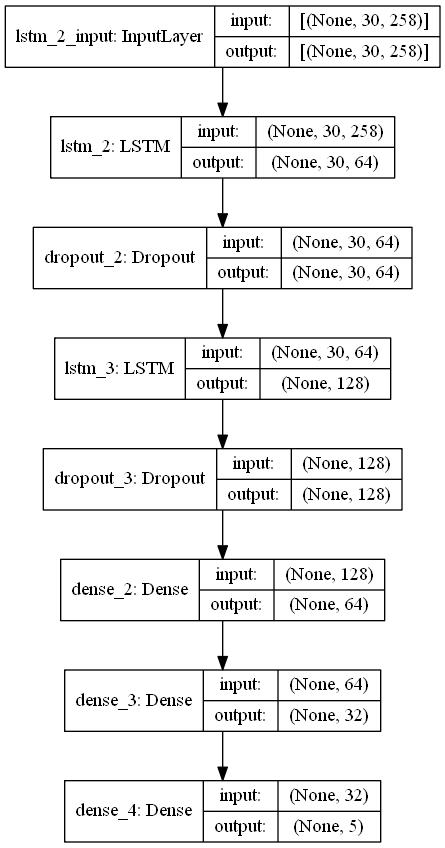

In [9]:
import pydot
import pydotplus
from pydotplus import graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, to_file=f'{img_dir}/model_plot.jpg', show_shapes=True, show_layer_names=True)

## 7.2 Define Model Parameters and Train Model

In [49]:
epochs = 500
#checkpoint_dir = f"Logs/{run}/tmp/checkpoint"
model_filename = "Epoch-{epoch:02d}-Loss-{val_loss:.2f}.h5"
checkpoint_filepath = os.path.join('model/',model_filename)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'Logs/{run}/'+checkpoint_filepath,
    monitor='val_loss', #get the minimum validation loss
    mode='min',
    save_weights_only=True,
    save_best_only=True,
    verbose=2)

# Reference: https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd
early_stopping =EarlyStopping(monitor='val_loss', patience=20,mode='auto',verbose=2)

In [50]:
# Reference: https://www.tensorflow.org/guide/keras/train_and_evaluate
print(f"Fit model on training data for {epochs} epochs")
history = model.fit(
    X_train, y_train, 
    #batch_size=64,
    epochs=epochs,
    # We pass some validation data for monitoring validation loss and metrics at the end of each epoch
    validation_data=(X_test, y_test),
    verbose=2,
    batch_size=32,
    callbacks=[tb_callback, model_checkpoint_callback, early_stopping]
)

#https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

Fit model on training data for 500 epochs
Epoch 1/500
8/8 - 11s - loss: 1.6539 - categorical_accuracy: 0.2042 - val_loss: 1.6376 - val_categorical_accuracy: 0.2000

Epoch 00001: val_loss improved from inf to 1.63761, saving model to Logs/run15/model\Epoch-01-Loss-1.64.h5
Epoch 2/500
8/8 - 1s - loss: 1.9278 - categorical_accuracy: 0.2625 - val_loss: 1.5562 - val_categorical_accuracy: 0.2833

Epoch 00002: val_loss improved from 1.63761 to 1.55621, saving model to Logs/run15/model\Epoch-02-Loss-1.56.h5
Epoch 3/500
8/8 - 1s - loss: 1.6855 - categorical_accuracy: 0.2958 - val_loss: 1.6148 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss did not improve from 1.55621
Epoch 4/500
8/8 - 1s - loss: 1.6085 - categorical_accuracy: 0.2167 - val_loss: 1.6067 - val_categorical_accuracy: 0.2000

Epoch 00004: val_loss did not improve from 1.55621
Epoch 5/500
8/8 - 1s - loss: 1.6056 - categorical_accuracy: 0.2083 - val_loss: 1.5973 - val_categorical_accuracy: 0.2167

Epoch 00005: val_loss did n


Epoch 00044: val_loss did not improve from 0.43030
Epoch 45/500
8/8 - 1s - loss: 1.0661 - categorical_accuracy: 0.5750 - val_loss: 0.9713 - val_categorical_accuracy: 0.5500

Epoch 00045: val_loss did not improve from 0.43030
Epoch 46/500
8/8 - 1s - loss: 0.9706 - categorical_accuracy: 0.6292 - val_loss: 0.9426 - val_categorical_accuracy: 0.5333

Epoch 00046: val_loss did not improve from 0.43030
Epoch 47/500
8/8 - 1s - loss: 0.8639 - categorical_accuracy: 0.6125 - val_loss: 0.7977 - val_categorical_accuracy: 0.6167

Epoch 00047: val_loss did not improve from 0.43030
Epoch 48/500
8/8 - 1s - loss: 0.7337 - categorical_accuracy: 0.6750 - val_loss: 0.6461 - val_categorical_accuracy: 0.6333

Epoch 00048: val_loss did not improve from 0.43030
Epoch 49/500
8/8 - 1s - loss: 2.1295 - categorical_accuracy: 0.6500 - val_loss: 0.8785 - val_categorical_accuracy: 0.5833

Epoch 00049: val_loss did not improve from 0.43030
Epoch 50/500
8/8 - 1s - loss: 0.7878 - categorical_accuracy: 0.6667 - val_loss

In [9]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


## 8. View Training Logs

In [60]:
log_dir

'Logs/run8'

In [82]:
#%reload_ext tensorboard

In [51]:
# Display Training Logs in Tensorboard 
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 21868), started 0:02:52 ago. (Use '!kill 21868' to kill it.)

## 9. Plot Training Results

In [52]:
import pandas as pd
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

hist_df.to_csv(f'./Logs/{run}/history.csv',index = False)

df_hist = pd.read_csv(f'./Logs/{run}/history.csv')
hist_df

loss  categorical_accuracy  val_loss  val_categorical_accuracy
0   1.653926              0.204167  1.637605                  0.200000
1   1.927821              0.262500  1.556212                  0.283333
2   1.685496              0.295833  1.614759                  0.200000
3   1.608471              0.216667  1.606685                  0.200000
4   1.605613              0.208333  1.597280                  0.216667
5   1.587353              0.333333  1.562410                  0.383333
6   1.433853              0.362500  1.652185                  0.083333
7   1.648635              0.137500  1.610288                  0.200000
8   1.617279              0.195833  1.605112                  0.233333
9   1.601204              0.216667  1.568648                  0.366667
10  1.523315              0.329167  1.479979                  0.366667
11  1.448877              0.337500  1.518440                  0.233333
12  1.575694              0.283333  1.562252                  0.366667
13  1.521340              0.358333  1.275955                  0.433333
14  1.224941              0.420833  1.083213                  0.550000
15  0.887650              0.545833  0.755413                  0.666667
16  0.764402              0.662500  0.976421                  0.550000
17  0.816428              0.641667  1.035392                  0.466667
18  0.946896              0.604167  1.353687                  0.400000
19  1.059841              0.470833  0.771465                  0.650000
20  0.762164              0.658333  0.768732                  0.666667
21  0.633966              0.708333  0.571070                  0.733333
22  0.559216              0.762500  0.690565                  0.683333
23  0.511676              0.791667  0.489302                  0.800000
24  0.626353              0.720833  1.059123                  0.533333
25  0.656350              0.679167  0.547048                  0.783333
26  0.441234              0.837500  0.580483                  0.716667
27  0.373068              0.862500  0.554909                  0.766667
28  0.418490              0.816667  0.453373                  0.783333
29  0.304598              0.879167  0.537647                  0.750000
30  0.511482              0.762500  0.744645                  0.633333
31  0.507001              0.766667  0.467383                  0.816667
32  0.356168              0.883333  0.430304                  0.833333
33  0.407850              0.837500  1.707270                  0.666667
34  1.205135              0.608333  0.995151                  0.516667
35  0.826221              0.645833  0.577931                  0.833333
36  0.648262              0.891667  0.569150                  0.733333
37  0.496023              0.833333  0.483709                  0.816667
38  0.383020              0.883333  0.508727                  0.733333
39  0.315670              0.875000  0.448853                  0.850000
40  0.304676              0.883333  0.434833                  0.816667
41  0.957247              0.654167  1.614167                  0.316667
42  1.313947              0.441667  1.220204                  0.433333
43  1.200672              0.500000  1.068589                  0.566667
44  1.066124              0.575000  0.971307                  0.550000
45  0.970564              0.629167  0.942609                  0.533333
46  0.863912              0.612500  0.797727                  0.616667
47  0.733691              0.675000  0.646076                  0.633333
48  2.129509              0.650000  0.878477                  0.583333
49  0.787778              0.666667  1.214941                  0.516667
50  2.592913              0.375000  1.525753                  0.200000
51  1.581993              0.200000  1.474607                  0.200000
52  1.550164              0.200000  1.444440                  0.283333

In [53]:
min_loss_epoch = hist_df[hist_df['loss']==min(hist_df['loss'])].index.values
min_loss = min(hist_df['loss'])
print('Index of Minimum Loss =',min_loss_epoch[0])
print('Minimum Loss =',round(min_loss,2))

Index of Minimum Loss = 29
Minimum Loss = 0.3


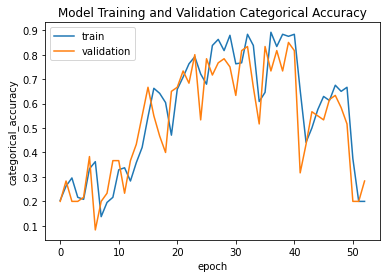

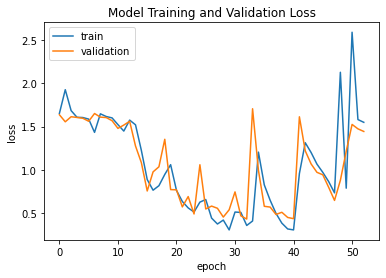

In [54]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Training and Validation Categorical Accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(f'{img_dir}/Model Training and Validation Categorical Accuracy.jpg')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(f'{img_dir}/Model Training and Validation Loss.jpg')
plt.show()

# 10. Load Best Model Weights/Checkpoint

In [17]:
# Initialise Model again after deleting model
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [132]:
# Build LSTM Model Architecture Layers using Keras high-level # including facemesh #run 13
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [49]:
# Build LSTM Model Architecture Layers using Keras high-level # run 12
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [25]:
# Build LSTM Model Architecture Layers using Keras high-level # run 11
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [17]:
# Build LSTM Model Architecture Layers using Keras high-level# run 10
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
#Dense layer with relu
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [57]:
# Build LSTM Model Architecture Layers using Keras high-level# run 9
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=False, activation='relu'))
#Dense layer with relu
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [19]:
# Build LSTM Model Architecture Layers using Keras high-level# run 8
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dropout(0.2))
#Dense layer with relu
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [17]:
# Build LSTM Model Architecture Layers using Keras high-level API #run7
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(Dropout(0.2))
#Dense layer with relu
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [59]:
# Build LSTM Model Architecture Layers using Keras high-level (First Model)
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
#Compile defines the loss function, the optimizer and the metrics. 
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [184]:
actions = np.array(['Alligator','Butterfly','Cow','Elephant','Gorilla'])

In [60]:
#model.load_weights(f'./Logs/{run}/model/Epoch-144-Loss-0.53.h5')
#model.load_weights(f'./Logs/{run}/model/Epoch-237-Loss-0.12.h5')
#model.load_weights(f'./Logs/{run}/model/Epoch-33-Loss-0.08.h5')
#model.load_weights(f'./Logs/{run}/model/Epoch-17-Loss-0.07.h5')

#model.load_weights(f'./Logs/run10/model/Epoch-13-Loss-0.05.h5')
#model.load_weights(f'./Logs/run11/model/Epoch-121-Loss-0.00.h5')
#model.load_weights(f'./Logs/run12/model/Epoch-38-Loss-0.12.h5')

#model.load_weights('./models/animal_asl_5_classes_1000_epoch_action.h5')

model.load_weights('./Logs/run15/model/Epoch-33-Loss-0.43.h5')

In [58]:
del model

# 11. Make Predictions on X_test

In [19]:
res = model.predict(X_test)

# Get y_predict and apply softmax function
np.argmax(res[4])

1

In [20]:
# Predicted Action
actions[np.argmax(res[4])]

'Butterfly'

In [21]:
# Actual Action
actions[np.argmax(y_test[4])]

'Butterfly'

In [22]:
actions[y_test[1]]

array(['Bird', 'Bird', 'Butterfly', 'Bird', 'Bird', 'Bird'], dtype='<U9')

# 12. Model Evaluation (Categorical Accuracy and Confusion Matrix)

Running these cells converts the predicition from their one-hot encoded representation to a categorical label e.g. 0,1 or 2 as opoosed to [1,0,0], [0,1,0] or [0,0,1].

In [23]:
X_test.shape

(72, 30, 258)

In [11]:
label_list = ['Alligator','Butterfly','Cow','Elephant','Gorilla']
label_list

['Alligator', 'Butterfly', 'Cow', 'Elephant', 'Gorilla']

In [10]:
label_list = list(label_map.keys())
label_list

AttributeError: 'list' object has no attribute 'keys'

Train Overall Multiclassification Accuracy Score across all classes: 0.88


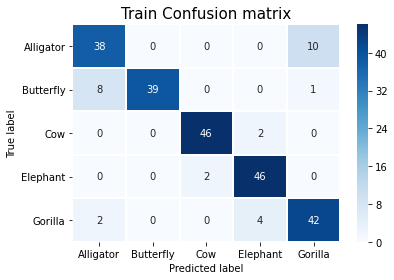

In [61]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def generate_confusion_matrix_accuracy(X,y,types):
    predictions = model.predict(X)
    y_true = np.argmax(y, axis=1)
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    print(f'{types} Overall Multiclassification Accuracy Score across all classes:',round(accuracy_score(y_true, y_pred),2))

    sns.heatmap(cm, xticklabels = label_list, yticklabels = label_list, annot = True, linewidths = 0.1, fmt='d',cmap='Blues') # cmap = 'YlGnBu')
    plt.title(f"{types} Confusion matrix", fontsize = 15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
generate_confusion_matrix_accuracy(X_train,y_train,'Train')

Test Overall Multiclassification Accuracy Score across all classes: 0.83


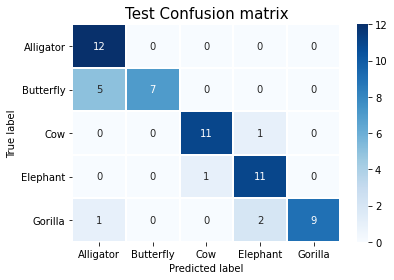

In [62]:
generate_confusion_matrix_accuracy(X_test,y_test,'Test')

# 13. Run Real Time Keypoint Detection Model Using Webcam

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

# Use Holistic Models for detections
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

# Make keypoint detection, model can only detect in RGB
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB as model can only detect in RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Use Model to make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results): # draw landmarks for each image/frame
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    
    
def draw_styled_landmarks(image, results): # draw landmarks for each image/frame, fix colour of landmark drawn
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 
    
# define extract keypoint function
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) # concatenate all the keypoints that are flattened
    #return np.concatenate([pose, lh, rh])

# Path for exported data, numpy arrays
#DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['Alligator','Butterfly','Cow','Elephant','Gorilla'])
#actions = np.array(['Bird','Butterfly','Cow','Elephant','Gorilla'])
#actions = np.array(['Bird','Butterfly','Cow','Elephant','Gorilla','No Action'])

# Thirty videos worth of data for each action
no_sequences = 30

# Videos are going to be 30 frames in length (30 frames of data for each action)
sequence_length = 30

label_map = {label:num for num, label in enumerate(actions)} #create label map dictionary

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard


# Build Model Architecture
#model = Sequential()
#model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
#model.add(LSTM(128, return_sequences=True, activation='relu'))
#model.add(Dropout(0.2))
#model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
#model.add(Dense(actions.shape[0], activation='softmax'))

#model = Sequential()
#model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
#model.add(LSTM(128, return_sequences=True, activation='relu'))
#model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
#model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
#model.add(Dense(actions.shape[0], activation='softmax'))

# Build LSTM Model Architecture Layers using Keras high-level # including facemesh #run 13
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662))) #each video has input shape of 30 frames of 1662 keypoints: X.shape
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu')) #next layer is a dense layer so we do not return sequences here
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# use categorical cross entropy as we are building a multiclass model
#metrics to track the accruacy of our model

#model_name = 'animal_asl_5_classes_1000_epoch_action'
#model.load_weights('models/{}.h5'.format(model_name))

#model_dir = 'Logs/run6/model'
#model_name = 'Epoch-209-Loss-0.00.h5'
#model.load_weights(f'{model_dir}/{model_name}')

#model.load_weights('./Logs/run13/model/Epoch-82-Loss-0.01.h5')
model.load_weights('./models/animal_asl_5_classes_1000_epoch_action.h5')
#model.load_weights('tutorial_weights_action.h5')

colors = [(245,221,173), (245,185,265), (146,235,193),(204,152,295),(255,217,179),(0,0,179)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1) #change length of bar depending on probability
        cv2.putText(output_frame, actions[num]+' '+str(round(prob*100,2))+'%', (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

def add_image(image,results, action):
    #height,width = image.shape
    #print(image.shape)
    width = image.shape[1]#480
    height= image.shape[0]#640

    def overlay_transparent(background, overlay, x, y):
        
        # height and width of background image
        background_width = background.shape[1]
        background_height = background.shape[0]
        
        # if coordinate x and y is larger than background width and height, stop code
        if x >= background_width or y >= background_height:
            return background

        # height and width of overlay image
        h, w = overlay.shape[0], overlay.shape[1]

        #print('x:',x)
        #print('overlay_width:',w)
        #print('background_width:',background_width)
        #print('y:',y)
        #print('overlay_height:',h)
        #print('background_height:',background_width)

        if w >= background_width:
            return background
        if h >= background_height:
            return background
        
        # if coordinate x + width of overlay is larger than background width and height, stop code
        if x + w > background_width:
            #w = background_width - x
            #overlay = overlay[:, :w]
            return background
        if x - w < 2:
            #w = background_width - x
            #overlay = overlay[:, :w]
            return background
        if y + h > background_height:
            #h = background_height - y
            #overlay = overlay[:h]
            return background
        
        if y - h < 2:
            #h = background_height - y
            #overlay = overlay[:h]
            return background
        
        if overlay.shape[2] < 4:
            overlay = np.concatenate(
                [
                    overlay,
                    np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
                ],
                axis = 2,
            )

        overlay_image = overlay[..., :3]
        mask = overlay[..., 3:] / 255.0

        background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

        return background

    index = 10
    
    face_keypoint=np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark])if results.face_landmarks else np.zeros(468*3)
    #print(len(face_keypoint))
    #print(action)
    if face_keypoint.size != 0 and np.any(face_keypoint[index]) == True:

        if action =='Bird':
            file_name = './emoji/bird.png'
        elif action =='Butterfly':
            file_name = './emoji/butterfly.png'
        elif action =='Gorilla':
            file_name = './emoji/gorilla.png'
        elif action == 'Cow':
            file_name = './emoji/cow.png'
        elif action == 'Elephant':
            file_name = './emoji/elephant.png'
        elif action == 'Alligator':
            file_name = './emoji/alligator.png'
        else:
            file_name = './emoji/No_sign.png'
            
        if action != 'No Action':    
            overlay= cv2.imread(file_name, cv2.IMREAD_UNCHANGED)

            #overlay= cv2.resize(overlay, (0,0), fx=min(0.1,float(1/face_keypoint[index][2]*-20)), fy=min(0.1,float(1/face_keypoint[index][2]*-20)))
            #print('z normalized',face_keypoint[index][2])
            #if face_keypoint[index][2]*-100 >1:
                #print('close to camera')
            #else:
                #print('far from camera')

            new_z = 0.1/((float(face_keypoint[index][2]*10)-(-1))/(1+1))
            #print('new_z',new_z)
            #print('z ',face_keypoint[index][2]*-10)
            #print('fx:',new_z)
            #print('fy:',new_z)

            #print(min(0.5,float(new_z)))

            overlay= cv2.resize(overlay, (0,0), fx=min(0.5,abs(float(new_z))), fy=min(0.5,abs(float(new_z))))

            #print('Normalized',face_keypoint[index])
            x = int(float(face_keypoint[index][0])*width)
            y = int(float(face_keypoint[index][1])*height)
            #print('Actual x',x)
            #print('Actual y',y)
            #cv2.circle(image,(x,y),3,(255,255,0),thickness= -1)

            #overlay = img2.copy()
            #image = cv2.rectangle(image, (x,y), (x+overlay.shape[1],y-overlay.shape[0]), (255,0,0), 3)

            #image = cv2.addWeighted(image,0.4,overlay,0.1,0)

            image = overlay_transparent(image, overlay, x - int(overlay.shape[0]/2), y-overlay.shape[0])


            #Setting the paste destination coordinates. For the time being, in the upper left
            #x1, y1, x2, y2 = x, y, overlay.shape[1], overlay.shape[0]

            #Synthetic!
            #image[y1:y2, x1:x2] = overlay[y1:y2, x1:x2]

In [21]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
videoWriter = cv2.VideoWriter('testvideo.avi', fourcc, 10, (640,480))

#import pafy
#import cv2
#url = "https://www.youtube.com/watch?v=jcnSKdZFr-M&ab_channel=ASLTHAT"
#video = pafy.new(url)
#best = video.getbest(preftype="mp4")
#cap = cv2.VideoCapture(best.url)
#cap = cv2.VideoCapture('./gif/combined.mp4')

# use computer webcam and make keypoint detections
cap = cv2.VideoCapture(0)

count = 0
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        # Read feed
        ret, image = cap.read()
        #if not ret:
            #break
        if ret == True:    
        #fps = cap.get(cv2.CAP_PROP_FPS)
        #print(fps)
        # for youtube video
        #width = 640
        #height = 480
        #dim = (width, height)
        #frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

            # Make detections
            image, results = mediapipe_detection(image, holistic)
            #print(results)
            #print(results.face_landmarks)
            #print(type(results.face_landmarks))

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # 2. Prediction logic
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)

            #if sequence[1] != None
            #print('face seq',sequence)
            
            # gets the most recent 30 frames
            sequence = sequence[-30:]

            if len(sequence) == 30:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                #print(actions[np.argmax(res)])
                predictions.append(np.argmax(res))

            #3. Viz logic
                if np.unique(predictions[-10:])[0]==np.argmax(res): 
                    if res[np.argmax(res)] > threshold: 
                        # Add_image
                        add_image(image, results, str(actions[np.argmax(res)]))
                        
                        if len(sentence) > 0: 
                            # if action is not in the last sentence, then we append the last action to the sentence
                            if actions[np.argmax(res)] != sentence[-1]: 
                                sentence.append(actions[np.argmax(res)])

                        else:
                            sentence.append(actions[np.argmax(res)])
                        
                    
                if len(sentence) > 5: 
                    sentence = sentence[-5:]

                # Viz probabilities
                image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
                #cv2.imwrite(f'{count}butterfly.jpg', image)
                #count +=1
            # Show to screen
            cv2.imshow('OpenCV Feed', image)
            
            #if str(actions[np.argmax(res)]) == 'Gorilla' and count >= 60:
                #break
            #cv2.imwrite(f'test/{count}.jpg', image)
            videoWriter.write(image)
            
            #count +=1
            # Break gracefully
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            count+=1
    cap.release()
    videoWriter.release()
    cv2.destroyAllWindows()

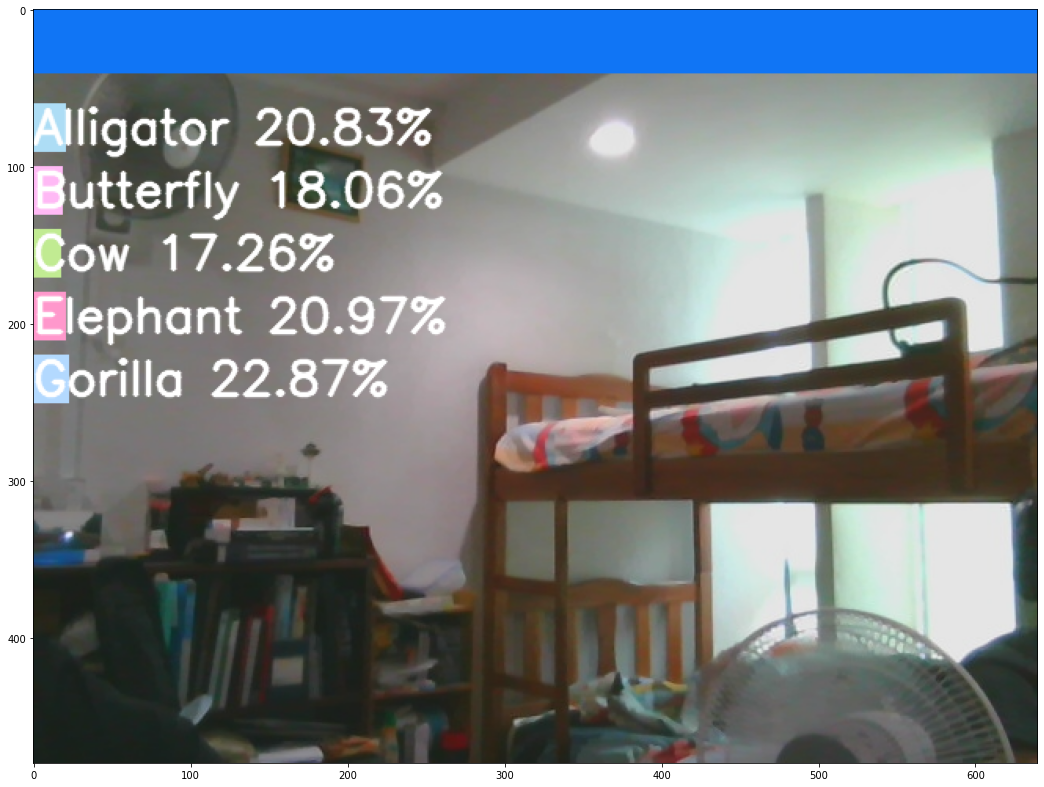

In [216]:
plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
#image = cv2.imread('0butterfly.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

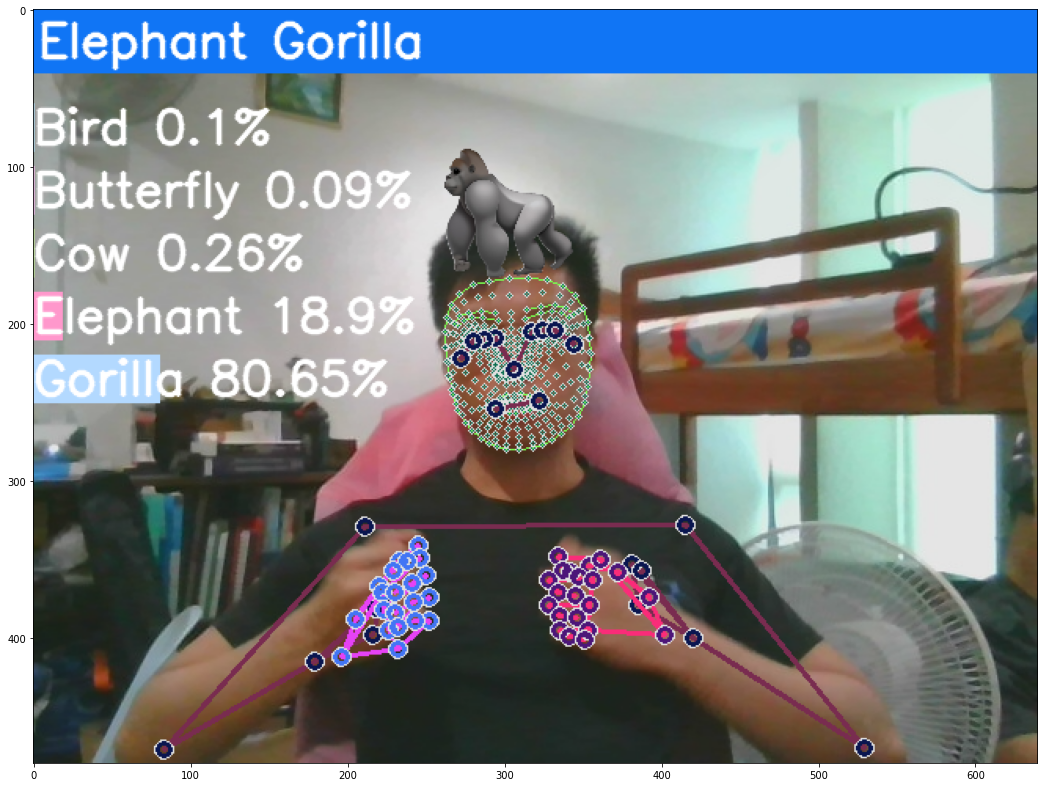

In [158]:
plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
#image = cv2.imread('0butterfly.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

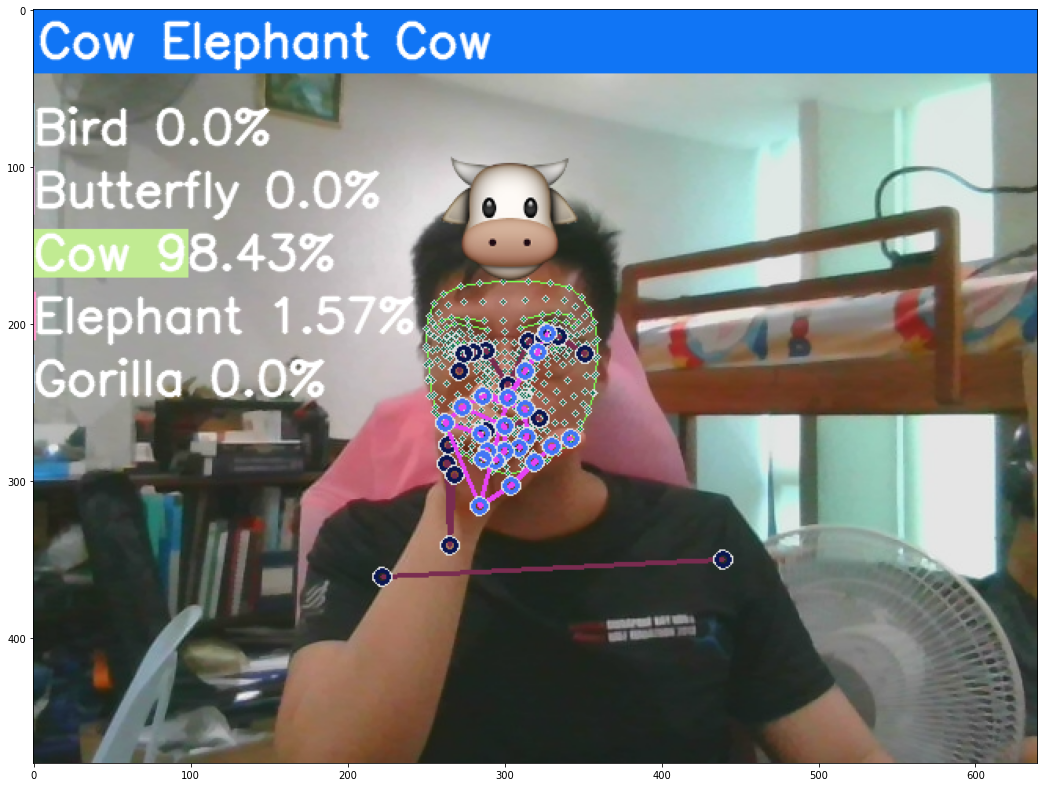

In [150]:
plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
#image = cv2.imread('0butterfly.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

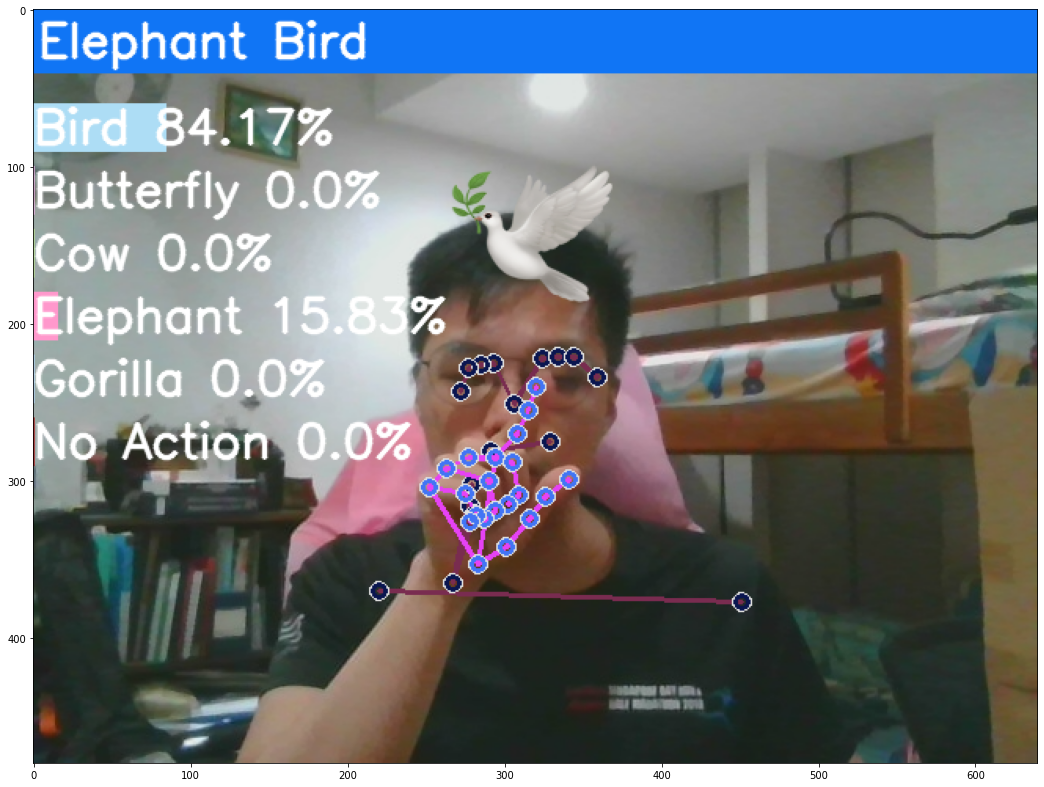

In [34]:
plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
#image = cv2.imread('0butterfly.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

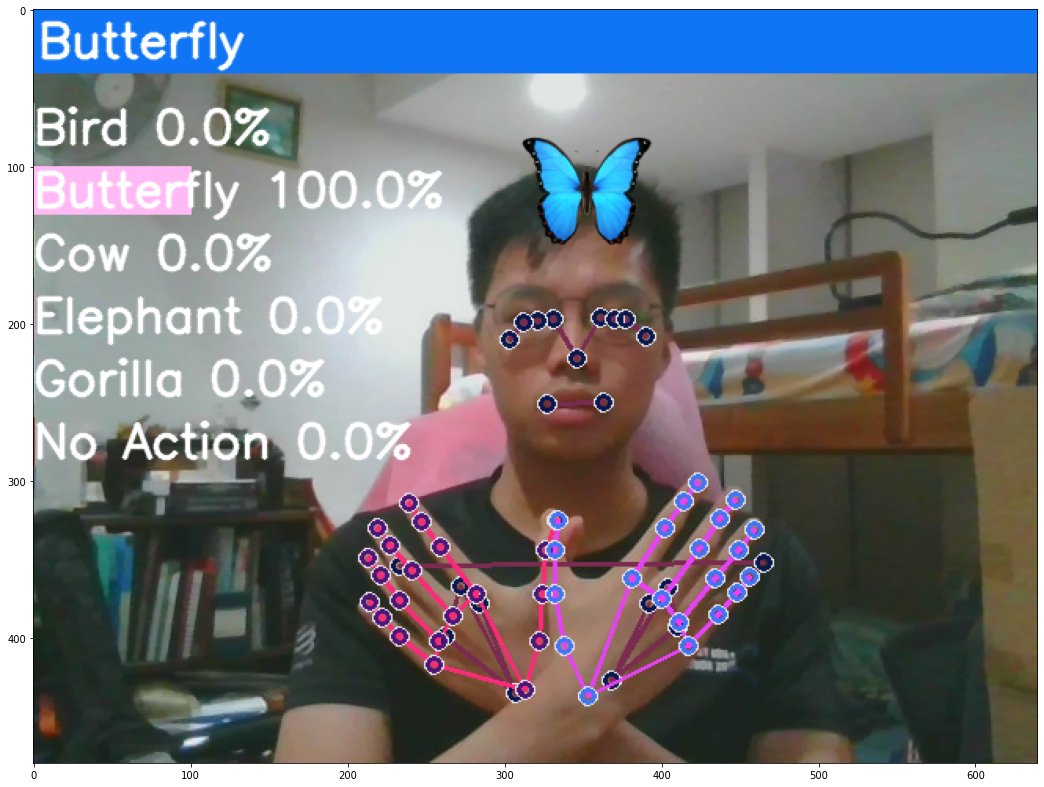

In [32]:
plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

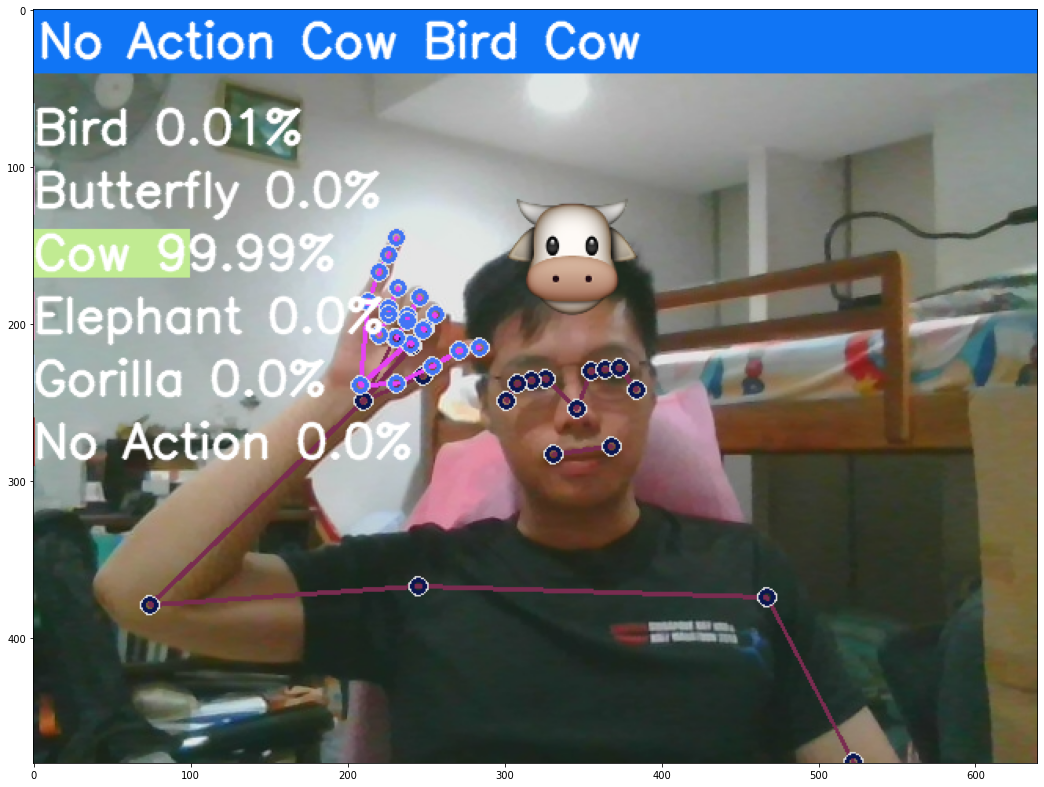

In [5]:
plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

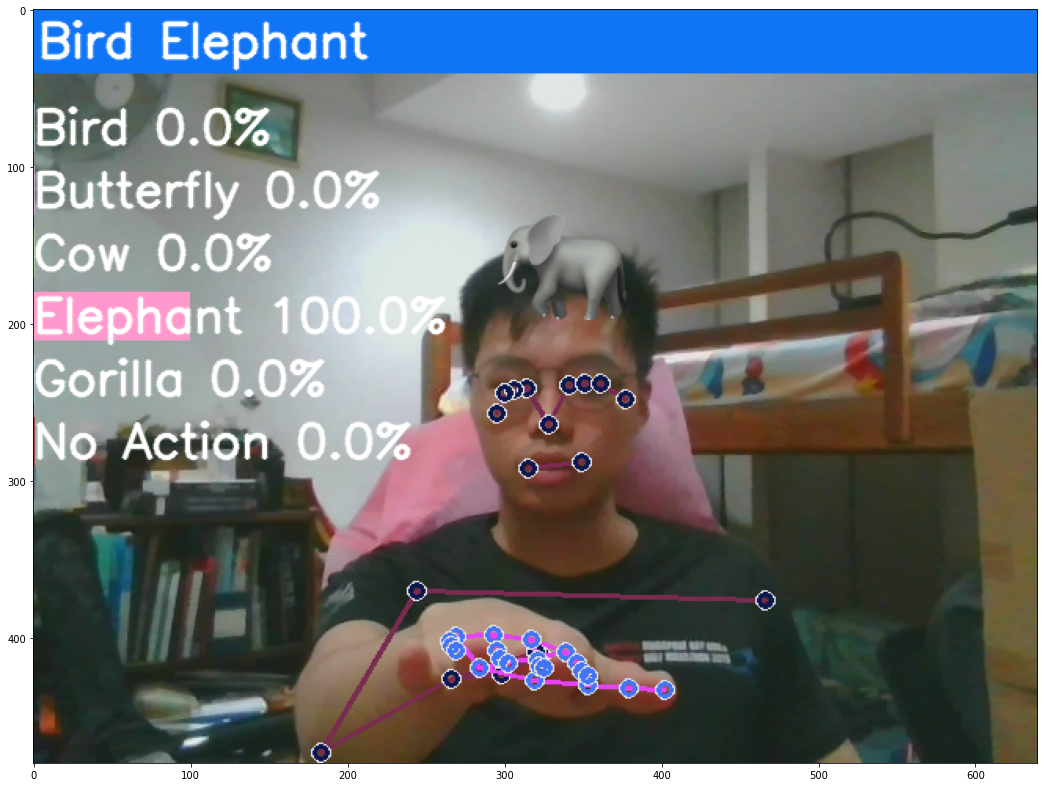

In [36]:
plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

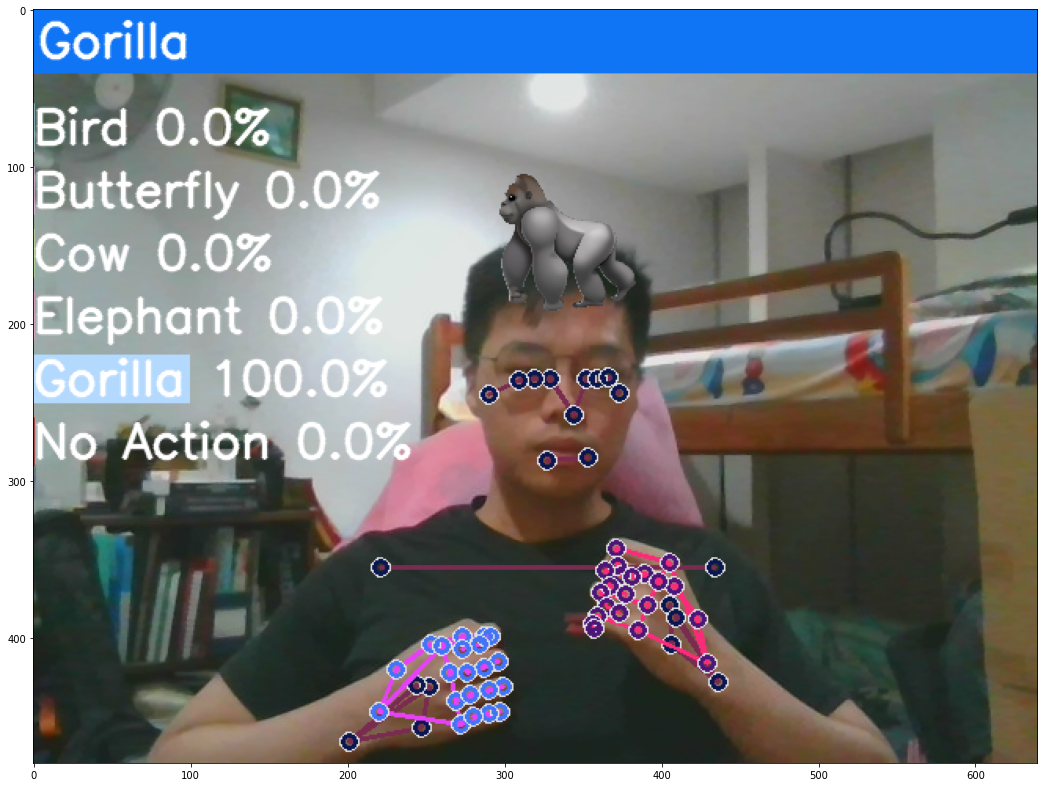

In [41]:
plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

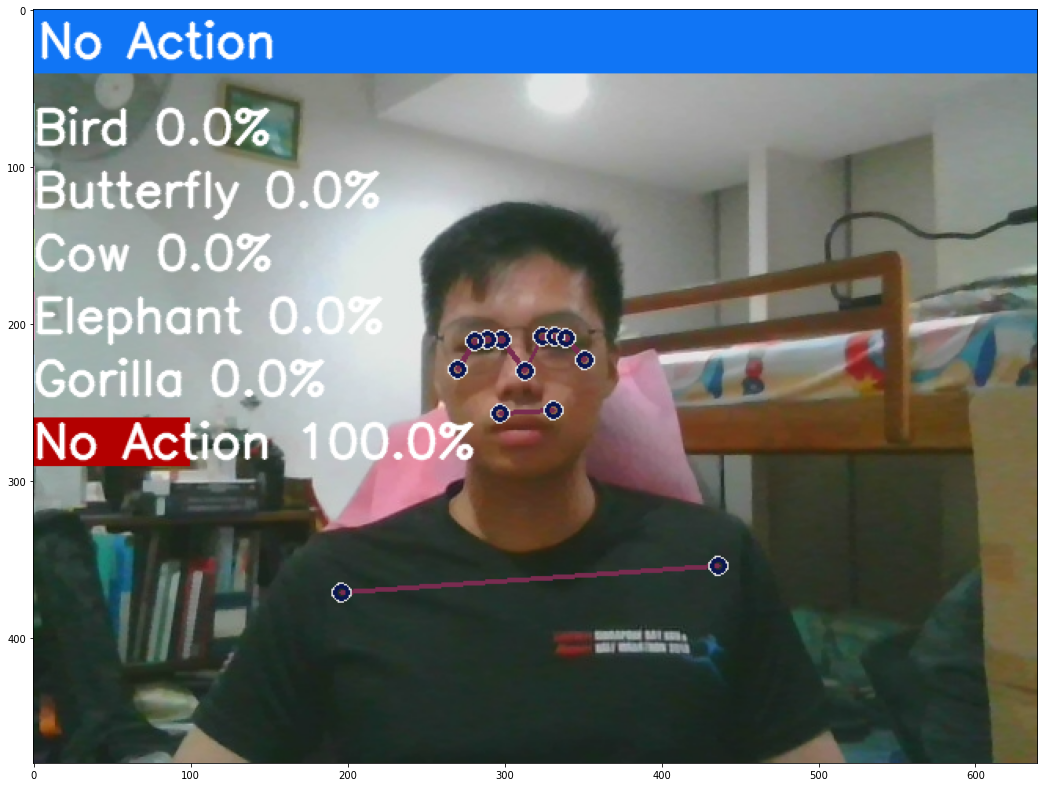

In [43]:
plt.figure(figsize=(18,18))
#plt.imshow(prob_viz(res, actions, image, colors))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## 13. Inference on Youtube and mp4 Video

In [27]:
!pip install pafy

In [28]:
!pip install youtube_dl

In [21]:
# use computer webcam and make keypoint detections
#url = "https://www.youtube.com/watch?v=jcnSKdZFr-M&ab_channel=ASLTHAT"
#video = pafy.new(url)
#best = video.getbest(preftype="mp4")

#capture = cv2.VideoCapture(best.url)

capture = cv2.VideoCapture('gif/bird.mp4')

#capture = cv2.VideoCapture(0)
 
fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
videoWriter = cv2.VideoWriter('bird_keypoint.avi', fourcc, 30.0, (1280, 720))

# Set mediapipe model 
min_detection_confidence = 0.5
min_tracking_confidence= 0.5
with mp_holistic.Holistic(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) as holistic:
    while capture:
        # Read feed
        ret, frame = capture.read()
        
        if ret:
            #width = 640
            #height = 480
            height,width, channel = frame.shape
            dim = (width, height)
            #print(dim)
            frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
            #print(frame.shape)

            # Make detections by calling our function
            image, results = mediapipe_detection(frame, holistic) #mediapipe_detection(image, model) 
            #print(results)
            #print(results.face_landmarks)

            # Draw landmarks
            draw_styled_landmarks(image, results)
        
            # Show to screen
            cv2.imshow('OpenCV Feed', image)
            videoWriter.write(image)
        else:
            break

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'): #press q to quit
            break
    capture.release() #release webcam
    videoWriter.release()
    cv2.destroyAllWindows()

## 15. Inference on Screen Capture

In [2]:
!pip install mss

In [5]:
!pip install Tkinter

  ERROR: Could not find a version that satisfies the requirement Tkinter (from versions: none)
ERROR: No matching distribution found for Tkinter


In [7]:
import ctypes
user32 = ctypes.windll.user32
screensize = user32.GetSystemMetrics(0), user32.GetSystemMetrics(1)
screensize


(2560, 1440)

In [18]:
import numpy as np
import cv2
from mss import mss
from PIL import Image

#bounding_box = {'top': 100, 'left': 0, 'width': 400, 'height': 300}
bounding_box = {'top': 0, 'left': 0, 'width': screensize[0]//2, 'height': screensize[1]}

sct = mss()

# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

#import pafy
#import cv2
#url = "https://www.youtube.com/watch?v=jcnSKdZFr-M&ab_channel=ASLTHAT"
#video = pafy.new(url)
#best = video.getbest(preftype="mp4")
#cap = cv2.VideoCapture(best.url)
#cap = cv2.VideoCapture('./gif/combined.mp4')



count = 0
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while True:
        sct_img = sct.grab(bounding_box)
        

        image = np.array(sct_img)
        # Read feed
        #ret, image = cap.read()
        #if not ret:
            #break
        #if ret == True:    
        #fps = cap.get(cv2.CAP_PROP_FPS)
        #print(fps)
        # for youtube video
        #width = 640
        #height = 480
        #dim = (width, height)
        #frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

        # Make detections
        image, results = mediapipe_detection(image, holistic)
        #print(results)
        #print(results.face_landmarks)
        #print(type(results.face_landmarks))

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)

        #if sequence[1] != None
        #print('face seq',sequence)

        # gets the most recent 30 frames
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    # Add_image
                    add_image(image, results, str(actions[np.argmax(res)]))

                    if len(sentence) > 0: 
                        # if action is not in the last sentence, then we append the last action to the sentence
                        if actions[np.argmax(res)] != sentence[-1]: 
                            sentence.append(actions[np.argmax(res)])

                    else:
                        sentence.append(actions[np.argmax(res)])


            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            #cv2.imwrite(f'{count}butterfly.jpg', image)
            #count +=1
        # Show to screen
        #cv2.imshow('OpenCV Feed', image)
        cv2.imshow('screen capture', image)

        #if str(actions[np.argmax(res)]) == 'Gorilla' and count >= 60:
            #break
        #cv2.imwrite(f'test/{count}.jpg', image)
        #videoWriter.write(image)
        
        #count +=1
        # Break gracefully
        if (cv2.waitKey(1) & 0xFF) == ord('q'):
            cv2.destroyAllWindows()
            break
        count+=1
            
cv2.destroyAllWindows()

TypeError: __init__() got an unexpected keyword argument 'enable_segmentation'

In [85]:
import cv2
import numpy as np
import cv2
from mss import mss
from PIL import Image
from PIL import ImageGrab

#bounding_box = {'top': 100, 'left': 0, 'width': 400, 'height': 300}
bounding_box = {'top': 0, 'left': 0, 'width': screensize[0], 'height':screensize[1]}

sct = mss()

#capture = cv2.VideoCapture(0)
 
#fourcc = cv2.VideoWriter_fourcc('X','V','I','D')
#videoWriter = cv2.VideoWriter('video_demo_lstm.avi', fourcc, 30.0, (640,480))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('outofframe.avi', fourcc, 10, (screensize[0],screensize[1]-60))


while True:
        
    img = ImageGrab.grab(bbox=(0,0,screensize[0],screensize[1]-60)) #bbox specifies specific region (bbox= x,y,width,height)
    img_np = np.array(img)
    frame = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    cv2.imshow("test", frame)
    
    #sct_img = sct.grab(bounding_box)
    #print(sct_img)
    #print(sct_img)
    #print(sct_img.size)  
    #image = np.array(sct_img)
    #image = cv2.resize(image, (640, 480))
    #print(image.size)
    
    #cv2.imshow('video', image)
    videoWriter.write(frame)
    # Break gracefully
    if cv2.waitKey(10) & 0xFF == ord('q'): #press q to quit
        break
        
#capture.release()
videoWriter.release()
 
cv2.destroyAllWindows()